In [1]:
import sys
sys.path.insert(0, "/Users/pongpisit/Desktop/research/PDE-FIND/")
from misc import h5file
from function_collections import BIC_AIC, msemse, colvec
sys.path.insert(0, "/Users/pongpisit/Desktop/research/parametric-discovery/")
from best_subset import brute_force, brute_force_all_subsets
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from scipy.io import savemat, loadmat
import jax.numpy as jnp
from jaxfit import CurveFit

u_clean = loadmat("../Datasets/KdV_sine_rep_big.mat")['usol']
np.random.seed(0)
undenoised_u = u_clean + 0.01*np.abs(30)*(u_clean.std())*np.random.randn(u_clean.shape[0], u_clean.shape[1])

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.


In [2]:
# u*u_1
# ----------
# u_111+u*u_1
# ----------
# u_111+u*u_1+u*u_111

complexity = 2
X_pre, best_subsets, un, y_pre = h5file("./IPI_output_files/PMS_data.h5")
xaxis = loadmat("/Users/pongpisit/Desktop/research/PDE-FIND/Datasets/KdV_sine_rep_big.mat")['x']
if complexity == 2:
    a, b = np.linalg.lstsq(X_pre[:, np.where(best_subsets[complexity-1]>0)[0]], 
                           y_pre, 
                           rcond=None)[0].flatten()
    print(a, b)
    a, b = np.abs([a, b])
elif complexity == 3:
    a, b, c = np.linalg.lstsq(X_pre[:, np.where(best_subsets[complexity-1]>0)[0]], y_pre, 
                              rcond=None)[0].flatten()
    print(a, b, c)
    a, b, c = np.abs([a, b, c])

['X_pre', 'best_subsets', 'un', 'y_pre']
-0.9037167644398507 -0.9103100649234885


In [3]:
# cws
use_cws = True
cws_IPI_data = loadmat("../WSINDy_PDE_latest/outputs/KdV/kdv30_ksvdreg_outputs.mat")
cws_W = cws_IPI_data['W']; print(cws_W)
cws_W = cws_W[abs(cws_W)>0]
cws_W[-1] = cws_W[-1]*2
cws_W = np.abs(cws_W)

rhs_desc = np.array([e.tolist() for e in cws_IPI_data['tags_pde_G'][0]])
rhs_desc = rhs_desc[1:]
X_cws = cws_IPI_data['oG'][:, 1:]
y_cws = cws_IPI_data['b']

if use_cws:
    cws_W = brute_force(X_cws, y_cws, complexity)
    cws_W3 = brute_force(X_cws, y_cws, 3)
    print(msemse(X_cws@cws_W, y_cws))
    cws_W = cws_W[abs(cws_W)>0]
    if complexity == 2:
        cws_W[-1] = cws_W[-1]*2
        print(cws_W)
        a, b = np.abs(cws_W)
    elif complexity == 3:
        cws_W[-1] = cws_W[-1]*2
        cws_W[-2] = cws_W[-2]*2
        print(cws_W)
        a, b, c = np.abs(cws_W)

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.9950437 ]
 [ 0.        ]
 [ 0.        ]
 [-0.50073689]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
772.2903101152643
[-0.9950437  -1.00147377]


In [4]:
np.linalg.lstsq(np.hstack((X_cws[:, (3, 6)], np.ones_like(y_cws))), y_cws, rcond=None)

(array([[-0.99504237],
        [-0.50073632],
        [ 0.01624813]]),
 array([1085839.8065239]),
 3,
 array([1.53572912e+05, 2.57417846e+04, 3.74113065e+01]))

In [5]:
# Parameters
Lx = 20
Nx = 512
dealias = 3/2
stop_sim_time = 40
timestepper = d3.SBDF2
timestep = 3.2e-3 # 4e-3
dtype = np.float64

In [6]:
# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(-Lx, Lx), dealias=dealias)

In [7]:
# Fields
u = dist.Field(name='u', bases=xbasis)

In [8]:
# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)

In [9]:
# Problem
problem = d3.IVP([u], namespace=locals())
# a, b = 0.9601505537264142, 0.9601505537264142
if complexity == 2:
    epsilon = (float(2*cws_W3[-2]))*(1e-2)
    # problem.add_equation("dt(u) + a*dx(dx(dx(u))) = -b*u*dx(u)")
    problem.add_equation("dt(u) + a*dx(dx(dx(u))) = -b*u*dx(u) + epsilon")
elif complexity == 3:
    problem.add_equation("dt(u) + a*dx(dx(dx(u))) = -b*u*dx(u) - c*u*dx(dx(dx(u)))")

In [10]:
# Initial conditions
x = dist.local_grid(xbasis)

### GROUND ##
# u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)
# u['g'] = -np.sin(np.pi*x/20)

# u['g'] = undenoised_u[:, 0]
# u['g'] = un[:, 0]
# u['g'] = np.sin(-0.15645656*x)

In [11]:
def jax_initial_function(x, a): return jnp.sin(a*x)
# -0.15645656 = pysr_params init
recovered_params1 = np.array(CurveFit().curve_fit(jax_initial_function, 
                                                  xaxis.flatten(), 
                                                  un[:, 0], 
                                                  p0=[-0.15645656])[0])
u['g'] = np.sin(recovered_params1[0]*x)

2023-07-19 22:40:13,896 jax._src.dispatch 0/1 WARNING :: Finished tracing + transforming jit(convert_element_type) in 0.00034308433532714844 sec
2023-07-19 22:40:13,905 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-19 22:40:13,906 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-19 22:40:13,907 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-07-19 22:40:13,908 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-07-19 22:40:13,913 jax._src.dispatch 0/1 WARNING :: Finished tracing + transforming jit

In [12]:
recovered_params1[0]

-0.1564577903993788

In [13]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2023-07-19 22:40:14,332 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s


In [14]:
# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

2023-07-19 22:40:20,819 solvers 0/1 INFO :: Simulation stop time reached.


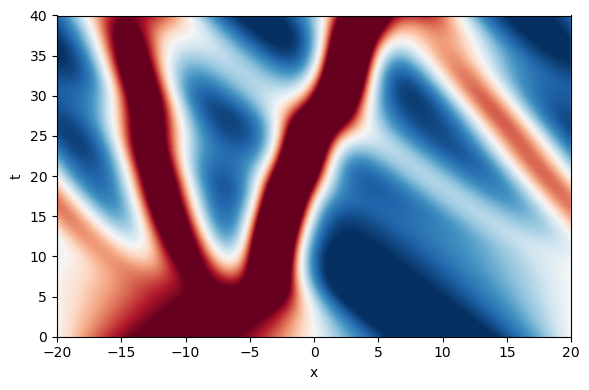

In [15]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-0.8, 0.8))
plt.xlim(-Lx, Lx)
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()
# plt.savefig('kdv_burgers.pdf')
# plt.savefig('kdv_burgers.png', dpi=200)

In [16]:
xx = x.ravel().reshape(1, -1)
tt = np.array(t_list).reshape(1, -1)
usol = np.array(u_list).T

In [17]:
print(BIC_AIC(colvec(usol), colvec(un), complexity))
print(BIC_AIC(colvec(usol), colvec(undenoised_u), complexity))
print(BIC_AIC(colvec(usol), colvec(u_clean), complexity))
msemse(usol, un)

(-731844.6328064174, -731865.5426678697)
(-67070.32397906213, -67091.23384051438)
(-1449458.289565099, -1449479.1994265511)


0.0033760930200692966

In [18]:
lr = LinearRegression(fit_intercept=True)
lr.fit(colvec(usol), colvec(un))
BIC_AIC(lr.predict(colvec(usol)), colvec(un), complexity)

(-732596.0396559368, -732616.9495173891)

In [19]:
cf_sim_usol = loadmat("../DeepHPMs/Matlab/KdV_sim/kdv_sim_CWF_com2.mat")['usol']
print(BIC_AIC(colvec(cf_sim_usol), colvec(un), 2))
print(BIC_AIC(colvec(cf_sim_usol), colvec(undenoised_u), 2))
print(BIC_AIC(colvec(cf_sim_usol), colvec(u_clean), 2))
msemse(cf_sim_usol, un)

(-708448.7909222144, -708469.7007836667)
(-65232.89169954239, -65253.801560994645)
(-1204577.0537171022, -1204597.9635785543)


0.0036984977432581597

In [24]:
cf_sim_usol = loadmat("../DeepHPMs/Matlab/KdV_sim/kdv_sim_CWF_adjustedIC_com2.mat")['usol']
print(BIC_AIC(colvec(cf_sim_usol), colvec(un), 2))
print(BIC_AIC(colvec(cf_sim_usol), colvec(undenoised_u), 2))
print(BIC_AIC(colvec(cf_sim_usol), colvec(u_clean), 2))
msemse(cf_sim_usol, un)

(-708492.719848676, -708513.6297101283)
(-65236.42854780784, -65257.33840926009)
(-1204869.323983592, -1204890.2338450442)


0.003697864411779714

In [21]:
##### Use conv weak form (CWS), use sin in jaxfit IC *** #####
# com=2
# -708616.9509167484
# com=2 + epsilon
# -731844.6328064384
# com=3
# -722890.3221166723

In [22]:
##### Use conv weak form (CWS), use sin in IC *** #####
# com=2
# -708573.4574643458
# com=2 + epsilon
# -731810.7242479663
# com=3
# -721720.6679410206

In [23]:
##### Use weak form (WF), use sin in IC #####
# com=2
# (-2988.5631005058417, -3009.4729619580903) | (-2980.3167505971974, -3001.226612049446) [By chebfun]
# com=3
# (-81246.04026289746, -81277.40505507583)